In this notebook, every salesman has a max load that can not be exceeded and missed locations will be punished.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import copy
import itertools


### Initialize the problem

In [2]:
numPoints = 30

# Generate random locations
X = []
Y = []

for i in range(numPoints):
    X.append(random.uniform(0,100))
    Y.append(random.uniform(0,100))
    

In [3]:
# Locations in a dataframe
df = pd.DataFrame()
df['ID'] = list(np.arange(1,numPoints+1))
df['X'] = X
df['Y'] = Y

# Put locations in a list
locations = list(df['ID'])


In [4]:
# Distance matrix
distance_matrix = []

for i in range(df.shape[0]):
    row = []
    
    for j in range(df.shape[0]):
        distance = np.sqrt((df['X'].iloc[i] - df['X'].iloc[j])**2 + (df['Y'].iloc[i] - df['Y'].iloc[j])**2)
        row.append(distance)
        
    distance_matrix.append(row)
    
# Make a copy of the distance matrix for manipulations
distance_matrix_copy = copy.deepcopy(distance_matrix)
distance_matrix_plot = copy.deepcopy(distance_matrix)
    

In [5]:
# Color dictionary to plot the solution
numbers = []
colors = []

for i in range(len(list(mcolors.CSS4_COLORS))):
    numbers.append(i)
 
# for bigger problems
colors = list(mcolors.CSS4_COLORS)
# for smaller problems
colors = list(mcolors.BASE_COLORS)

# Convert lists to dictionary
color_dict = {}
for key in numbers:
    for value in colors:
        color_dict[key] = value
        colors.remove(value)
        break


### Random selection of start location

In [6]:
# number of salesmen
SALESMEN = 5
SALESMEN_COST = 500
MAX_LOAD = 12
MISSING_LOCATION = 1000

locations_copy = copy.deepcopy(locations)
unused_locations = copy.deepcopy(locations)

# routes for the salesmen
res = []
LOAD = [0] * SALESMEN

START_LOCATIONS = []

start_location = random.sample(locations_copy, k=1)[0]
locations_copy.remove(start_location)
unused_locations.remove(start_location)

START_LOCATIONS.append(start_location)

for i in range(SALESMEN):
    res.append([start_location,start_location])


In [7]:
names = []

for i in range(df.shape[0]):
    if df['ID'].iloc[i] in START_LOCATIONS:
        names.append('Start')
    else:
        names.append(i+1)

df['NAME'] = names


In [8]:
# Create random intial route
for i in range(len(locations_copy)):
    
    # In case there are more locations than available total space
    try:
    
        # Route to insert (a new location can only be inserted if the load is below the max threshold)
        insertion = random.sample(list(np.where(np.array(LOAD) < MAX_LOAD)[0]), k=1)[0]
        LOAD[insertion] += 1

        # Select a random location to insert
        random_location = random.sample(locations_copy, k=1)[0]
        locations_copy.remove(random_location)
        unused_locations.remove(random_location)

        # Select a random spot to insert
        random_spot = random.sample(range(1,len(res[insertion])),k=1)[0]
        res[insertion].insert(random_spot,random_location)

    except: ValueError
    

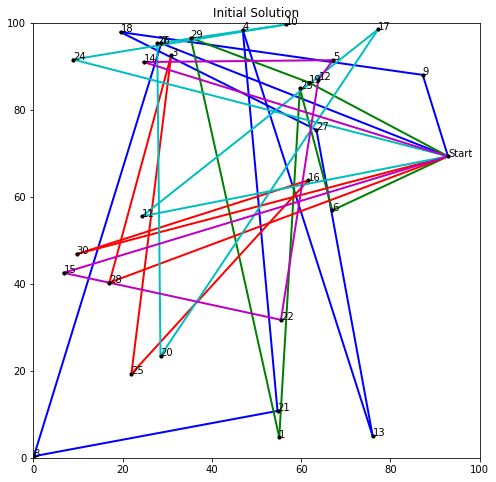

In [9]:
# Initial result
plt.figure(figsize=(8,8))
plt.scatter(df['X'], df['Y'], c='black', zorder=2000, s=10)

for i in range(numPoints):
    plt.annotate(text = df['NAME'].iloc[i], xy = (df['X'].iloc[i], df['Y'].iloc[i]))

for k in range(len(res)):
    for i in range(len(res[k])-1):
        plt.plot((df['X'].iloc[res[k][i]-1],df['X'].iloc[res[k][i+1]-1]),
                 (df['Y'].iloc[res[k][i]-1],df['Y'].iloc[res[k][i+1]-1]),
                  c=color_dict[k], linewidth=2)
            
plt.title('Initial Solution')
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


### Solving the problem

In [10]:
locations_copy = copy.deepcopy(locations)
locations_copy.remove(start_location)


In [11]:
### Branch-and-cut Solution

# Develeopment of the solution
history = []

# shortest route
shortest_route = [0]*SALESMEN

for i in range(len(res)):
    for j in range(len(res[i])-1):
        shortest_route[i] += distance_matrix_copy[res[i][j]-1][res[i][j+1]-1]
    if len(res[i]) > 2:
        shortest_route[i] += SALESMEN_COST
      
# Objective
objective = sum(shortest_route) + MISSING_LOCATION * len(unused_locations)
history.append(objective)

print(res)
print('Lengths of the routes:', shortest_route)
print('Objective initial solution:', objective)


[[2, 7, 8, 21, 4, 13, 27, 18, 9, 2], [2, 19, 29, 1, 23, 6, 2], [2, 30, 16, 25, 3, 28, 2], [2, 11, 17, 20, 26, 10, 24, 2], [2, 15, 22, 12, 5, 14, 2]]
Lengths of the routes: [1118.5173387486138, 795.8615487108432, 909.3338305160132, 963.7965793542754, 815.4973714886671]
Objective initial solution: 4603.006668818412


In [12]:
# Initial solution
print(res)
print('Lengths of the routes:', shortest_route)
print('Current best solution:', objective)
print()

for tries in range(10000):

    # maximum number of locations to remove
    max_removes = int(np.round(len(locations)/2))

    # make a copy of the current route
    res_interim = copy.deepcopy(res)
    LOAD_interim = copy.deepcopy(LOAD)

    # locations to remove (at least 1)
    number = random.sample(range(1,max_removes), 1)[0]
    loc_remove = random.sample(locations_copy, number)

    # remove locations from route
    for loc in (loc_remove):   
        for i in range(len(res_interim)):
            if loc in res_interim[i]:
                res_interim[i].remove(loc)
                LOAD_interim[i] -= 1

    try:
        
        # randomly insert locations into result
        for loc in (loc_remove):
            # Route to insert
            insertion = random.sample(list(np.where(np.array(LOAD_interim) < MAX_LOAD)[0]), k=1)[0]
            LOAD_interim[insertion] += 1

            insert_position = np.random.randint(1,len(res_interim[insertion]))
            res_interim[insertion].insert(insert_position, loc)
            
    except: ValueError

    current_route_interim = [0]*SALESMEN

    for i in range(len(res_interim)):
        for j in range(len(res_interim[i])-1):
            current_route_interim[i] += distance_matrix_copy[res_interim[i][j]-1][res_interim[i][j+1]-1]
        if len(res_interim[i]) > 2:
            current_route_interim[i] += SALESMEN_COST

    current_objective = sum(current_route_interim)
    
    # Locations that are not part of the solution
    used_locations = []

    for i in range(len(res_interim)):
        for k in range(len(locations)):
            if locations[k] in res_interim[i]:
                used_locations.append(locations[k])
                
    unused_locations = [x for x in locations if x not in used_locations]

    if current_objective + MISSING_LOCATION * len(unused_locations) < objective:
        objective = current_objective + MISSING_LOCATION * len(unused_locations)
        res = res_interim
        LOAD = LOAD_interim

    history.append(objective)

print(res)

# Objective
shortest_route = [0]*SALESMEN

for i in range(len(res)):
    for j in range(len(res[i])-1):
        shortest_route[i] += distance_matrix_copy[res[i][j]-1][res[i][j+1]-1]
    if len(res[i]) > 2:
        shortest_route[i] += SALESMEN_COST
        
print('Lengths of the routes:', shortest_route)
print('Objective:', objective)


[[2, 7, 8, 21, 4, 13, 27, 18, 9, 2], [2, 19, 29, 1, 23, 6, 2], [2, 30, 16, 25, 3, 28, 2], [2, 11, 17, 20, 26, 10, 24, 2], [2, 15, 22, 12, 5, 14, 2]]
Lengths of the routes: [1118.5173387486138, 795.8615487108432, 909.3338305160132, 963.7965793542754, 815.4973714886671]
Current best solution: 4603.006668818412

[[2, 9, 17, 5, 10, 27, 13, 1, 21, 2], [2, 2], [2, 12, 4, 29, 19, 2], [2, 16, 11, 24, 18, 7, 26, 14, 3, 23, 2], [2, 22, 8, 25, 20, 28, 15, 30, 6, 2]]
Lengths of the routes: [753.2243424018832, 0.0, 630.093930624127, 709.9979515318896, 776.2902229007134]
Objective: 2869.606447458613


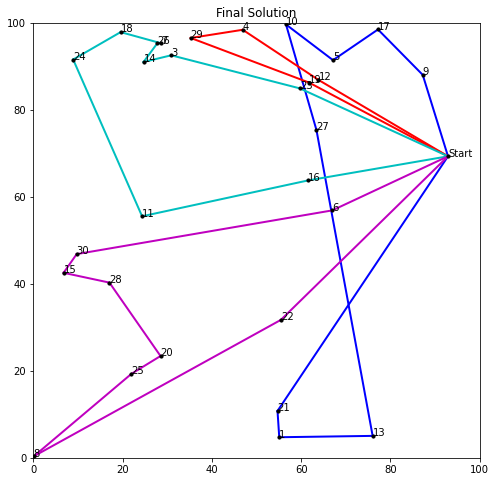

In [13]:
# Final result
plt.figure(figsize=(8,8))
plt.scatter(df['X'], df['Y'], c='black', zorder=2000, s=10)

for i in range(numPoints):
    plt.annotate(text = df['NAME'].iloc[i], xy = (df['X'].iloc[i], df['Y'].iloc[i]))

for k in range(len(res)):
    for i in range(len(res[k])-1):
        plt.plot((df['X'].iloc[res[k][i]-1],df['X'].iloc[res[k][i+1]-1]),
                 (df['Y'].iloc[res[k][i]-1],df['Y'].iloc[res[k][i+1]-1]),
                  c=color_dict[k], linewidth=2)
            
plt.title('Final Solution')
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


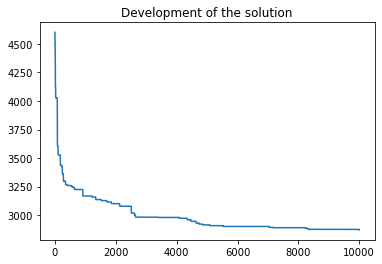

In [14]:
plt.plot(history)
plt.title('Development of the solution')
plt.show()
